In [44]:
# Importing libraries

import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [45]:
# reading googl data

df = pd.read_csv("Iot_stock_2020ToJune2023data.csv")
df.head()

,timestamp,open,high,low,close,volume,trade_count,vwap,symbol
0,2021-12-15 17:00:00+00:00,24.90,25.2500,24.22,24.7495,5874118,20055,24.804015,IOT
1,2021-12-15 18:00:00+00:00,24.75,24.7800,24.01,24.3100,1972471,13712,24.414842,IOT
2,2021-12-15 19:00:00+00:00,24.31,24.4048,23.75,23.7500,1829511,11749,23.988570,IOT
3,2021-12-15 20:00:00+00:00,23.76,24.7800,23.75,24.7000,2529840,14197,24.306750,IOT
4,2021-12-15 21:00:00+00:00,24.70,24.9000,24.56,24.8799,230773,145,24.716130,IOT


In [46]:
df.tail()

,timestamp,open,high,low,close,volume,trade_count,vwap,symbol
3772,2023-06-16 19:00:00+00:00,28.63,28.9500,28.585,28.915,1374166,11412,28.826813,IOT
3773,2023-06-16 20:00:00+00:00,28.90,28.9001,28.700,28.700,2552890,31,28.899984,IOT
3774,2023-06-16 21:00:00+00:00,28.93,28.9300,28.930,28.930,353,8,28.932436,IOT
3775,2023-06-16 22:00:00+00:00,28.93,28.9300,28.910,28.910,1657,12,28.924382,IOT
3776,2023-06-16 23:00:00+00:00,28.93,28.9700,28.680,28.970,976,11,28.823853,IOT


#### We have data from 2020 to 2023 June 16

In [47]:
# Checking general summary of the columns and their datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777 entries, 0 to 3776
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    3777 non-null   object 
 1   open         3777 non-null   float64
 2   high         3777 non-null   float64
 3   low          3777 non-null   float64
 4   close        3777 non-null   float64
 5   volume       3777 non-null   int64  
 6   trade_count  3777 non-null   int64  
 7   vwap         3777 non-null   float64
 8   symbol       3777 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 265.7+ KB


In [48]:
# checking for missing values

df.isnull().sum()

timestamp      0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
symbol         0
dtype: int64

In [49]:
# Checking summary statistics of the data

df.describe()

,open,high,low,close,volume,trade_count,vwap
count,3777.000000,3777.000000,3777.000000,3777.000000,3.777000e+03,3777.000000,3777.000000
mean,16.142401,16.304705,15.980191,16.143203,2.053141e+05,1636.831083,16.138227
std,4.863017,4.910315,4.817697,4.864630,3.555559e+05,2197.661576,4.858159
min,8.530000,8.620000,8.420000,8.530000,2.000000e+00,1.000000,8.506178
25%,12.290000,12.405800,12.180000,12.280000,3.941200e+04,13.000000,12.291534
50%,15.150000,15.320000,15.000000,15.130000,1.103820e+05,1100.000000,15.108520
75%,19.140000,19.299900,19.040000,19.160000,2.463930e+05,2258.000000,19.189900
max,31.000000,31.410000,30.800000,31.300000,7.189133e+06,38323.000000,30.960000


In [50]:
# Renaming timestamp column to "Date" and changing it's data type to datetime


df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
# df.index = range(len(df))

# Dropping column symbol

df = df.drop("symbol",1)
df.rename(columns = {"timestamp":"Date"},inplace=True)

df.head()

,Date,open,high,low,close,volume,trade_count,vwap
0,2021-12-15 17:00:00,24.90,25.2500,24.22,24.7495,5874118,20055,24.804015
1,2021-12-15 18:00:00,24.75,24.7800,24.01,24.3100,1972471,13712,24.414842
2,2021-12-15 19:00:00,24.31,24.4048,23.75,23.7500,1829511,11749,23.988570
3,2021-12-15 20:00:00,23.76,24.7800,23.75,24.7000,2529840,14197,24.306750
4,2021-12-15 21:00:00,24.70,24.9000,24.56,24.8799,230773,145,24.716130


In [51]:
# plotting OHLC Chart  (open/high/low/close) chart to see historical prices. 



fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close,
                      name='Price'), row=1, col=1)

# Plotting Volume chart which shows number of stocks traded each day below OHLC chart. 
fig.add_trace(go.Scatter(x=df.Date, y=df.volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

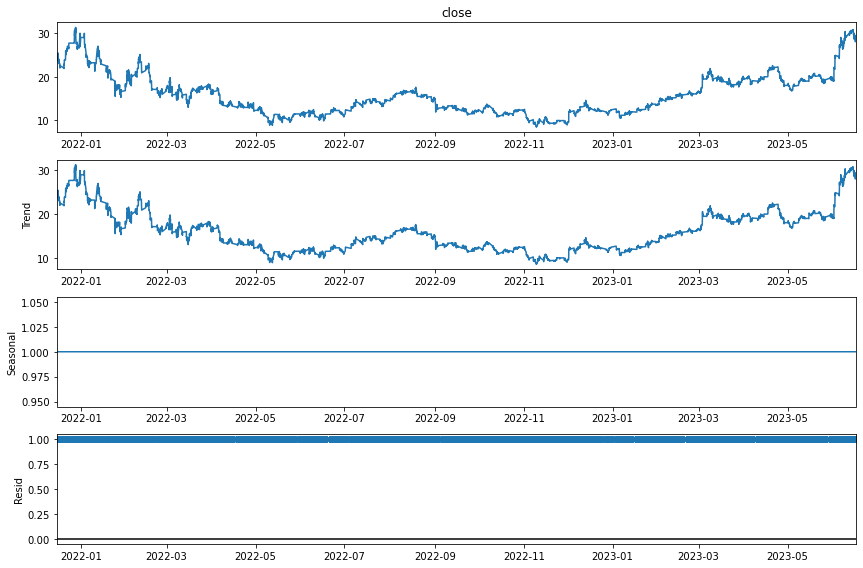

In [52]:
# Plotting Time series decomposition plots to see trend, seasonality

from pylab import rcParams
import statsmodels.api as sm


df_close = df[['Date', 'close']].copy()
df_close = df_close.set_index('Date')
df_close.sort_index(inplace=True)
#cdf_close.head()

rcParams["figure.figsize"]=12,8
decomposition = sm.tsa.seasonal_decompose(df_close.close, model ="multiplicative",extrapolate_trend='freq', period=1)
fig = decomposition.plot()
plt.show()

Plot clearly shows that there is no seasonality in the data all that we see is the trend

#### Technical Indicators

- Moving Averages -help to smooth out stock prices on a chart by filtering out short-term price fluctuations.
 We will calculate simple moving averages for 5,10,15,30 days and
 Exponential moving average for 10,20,30,40,50 days

In [53]:
df['EMA_10'] = df['close'].ewm(10).mean().shift()
df['EMA_15'] = df['close'].ewm(15).mean().shift()
df['EMA_20'] = df['close'].ewm(20).mean().shift()
df['EMA_25'] = df['close'].ewm(25).mean().shift()
df['EMA_30'] = df['close'].ewm(30).mean().shift()
df['EMA_40'] = df['close'].ewm(40).mean().shift()
df['EMA_50'] = df['close'].ewm(50).mean().shift()
df['SMA_5'] = df['close'].rolling(5).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_15'] = df['close'].rolling(15).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

'''
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_10, name='EMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_20, name='EMA 20'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_30, name='EMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_40, name='EMA 40'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_50, name='EMA 50'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.close, name='close', opacity=0.2))
fig.show() '''

"\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=df.Date, y=df.EMA_10, name='EMA 10'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.EMA_20, name='EMA 20'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.EMA_30, name='EMA 30'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.EMA_40, name='EMA 40'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.EMA_50, name='EMA 50'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))\nfig.add_trace(go.Scatter(x=df.Date, y=df.close, name='close', opacity=0.2))\nfig.show() "

In [54]:
df.head()

,Date,open,high,low,close,volume,trade_count,vwap,EMA_10,EMA_15,EMA_20,EMA_25,EMA_30,EMA_40,EMA_50,SMA_5,SMA_10,SMA_15,SMA_30
0,2021-12-15 17:00:00,24.90,25.2500,24.22,24.7495,5874118,20055,24.804015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-15 18:00:00,24.75,24.7800,24.01,24.3100,1972471,13712,24.414842,24.749500,24.749500,24.749500,24.749500,24.749500,24.749500,24.749500,NaN,NaN,NaN,NaN
2,2021-12-15 19:00:00,24.31,24.4048,23.75,23.7500,1829511,11749,23.988570,24.519286,24.522661,24.524390,24.525441,24.526148,24.527037,24.527574,NaN,NaN,NaN,NaN
3,2021-12-15 20:00:00,23.76,24.7800,23.75,24.7000,2529840,14197,24.306750,24.238066,24.248318,24.253569,24.256759,24.258904,24.261603,24.263234,NaN,NaN,NaN,NaN
4,2021-12-15 21:00:00,24.70,24.9000,24.56,24.8799,230773,145,24.716130,24.370545,24.372394,24.373472,24.374171,24.374659,24.375295,24.375690,NaN,NaN,NaN,NaN


#### Relative Strength Index

 - RSI indicator to predict whether a stock is overbought/oversold.
 - RSI value of 70 and above mean stock is overbought/overvalued, value of 30 and less can mean that it is oversold. Full range of RSI is from 0 to 100.

In [55]:
def relative_strength_idx(df, n=15):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

'''
fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show() '''

"\nfig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))\nfig.show() "

#### Moving Average Convergence/Divergence (MACD) and why MACD

- MACD is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a price. 
- The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA.
- A nine-day EMA of the MACD line is called the signal line, which is then plotted on top of the MACD line
- MACD can help gauge whether a security is overbought or oversold, alerting traders to the strength of a directional move, and warning of a potential price reversal.
- MACD can also alert investors to bullish/bearish divergences (e.g., when a new high in price is not confirmed by a new high in MACD, and vice versa), suggesting a potential failure and reversal.
- After a signal line crossover, it is recommended to wait for three or four days to confirm that it is not a false move.

In [56]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.close, name='close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

From the second plot above MACD(blue line) above signal line(orange) indicates that it is overbought

#### Shift label column
Since we want to predict the next hour price, shifting Close price column by -1 rows

In [57]:
df['close'] = df['close'].shift(-1)
df.head()

,Date,open,high,low,close,volume,trade_count,vwap,EMA_10,EMA_15,...,EMA_30,EMA_40,EMA_50,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-12-15 17:00:00,24.90,25.2500,24.22,24.3100,5874118,20055,24.804015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-15 18:00:00,24.75,24.7800,24.01,23.7500,1972471,13712,24.414842,24.749500,24.749500,...,24.749500,24.749500,24.749500,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2021-12-15 19:00:00,24.31,24.4048,23.75,24.7000,1829511,11749,23.988570,24.519286,24.522661,...,24.526148,24.527037,24.527574,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2021-12-15 20:00:00,23.76,24.7800,23.75,24.8799,2529840,14197,24.306750,24.238066,24.248318,...,24.258904,24.261603,24.263234,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2021-12-15 21:00:00,24.70,24.9000,24.56,24.8800,230773,145,24.716130,24.370545,24.372394,...,24.374659,24.375295,24.375690,NaN,NaN,NaN,NaN,0.0,NaN,NaN


### Drop invalid samples (Removing NANs)
- Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated  SMA10 for the first 10 days. 
- After shifting Close price column, last row price is equal to 0 so we need to remove them.

In [58]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [59]:
df.head()

,Date,open,high,low,close,volume,trade_count,vwap,EMA_10,EMA_15,...,EMA_30,EMA_40,EMA_50,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-12-17 23:00:00,22.5000,22.5000,22.5000,22.0000,220,4,22.475818,23.080200,23.302711,...,23.565777,23.635602,23.677845,22.24314,22.56819,22.914793,23.804223,34.636433,-0.466051,-0.460181
1,2021-12-20 12:00:00,22.0000,22.0000,22.0000,21.9001,100,1,22.000000,23.025306,23.246249,...,23.514619,23.586847,23.630710,22.34100,22.51618,22.823460,23.730890,35.269264,-0.480333,-0.464696
2,2021-12-20 13:00:00,21.9001,21.9001,21.9001,22.8800,150,1,21.900100,22.928657,23.159272,...,23.443044,23.519958,23.566757,22.32900,22.41618,22.737460,23.634893,24.151480,-0.493487,-0.470996
3,2021-12-20 14:00:00,22.1300,22.9900,22.1300,22.7000,213557,947,22.690652,22.832026,23.072029,...,23.371207,23.452870,23.502651,22.18402,22.30558,22.604133,23.535563,43.128154,-0.424089,-0.460922
4,2021-12-20 15:00:00,22.8800,23.0000,22.5300,22.9700,260743,1476,22.669500,22.836519,23.058814,...,23.348660,23.429541,23.479145,22.29602,22.29158,22.563467,23.473230,41.447254,-0.378560,-0.443491


In [60]:
df.isnull().sum()

Date           0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
EMA_10         0
EMA_15         0
EMA_20         0
EMA_25         0
EMA_30         0
EMA_40         0
EMA_50         0
SMA_5          0
SMA_10         0
SMA_15         0
SMA_30         0
RSI            0
MACD           0
MACD_signal    0
dtype: int64

#### Splitting data into train, validation and test set

- we are splitting training(80%), validation(10%) and test(10%)

In [61]:
test_size  = 0.10
valid_size = 0.10

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

'''
# Plot to show splits

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.close,  name='Test'))
fig.show() 
'''

"\n# Plot to show splits\n\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=train_df.Date, y=train_df.close, name='Training'))\nfig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.close, name='Validation'))\nfig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.close,  name='Test'))\nfig.show() \n"

In [62]:
df.columns

Index(['Date', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap',
       'EMA_10', 'EMA_15', 'EMA_20', 'EMA_25', 'EMA_30', 'EMA_40', 'EMA_50',
       'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'],
      dtype='object')

In [63]:
#### Dropping unnecessary columns

drop_cols = ['Date', 'trade_count', 'vwap']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

#### Splitting data to X and y datasets

In [64]:
y_train = train_df['close'].copy()
X_train = train_df.drop(['close'], 1)

y_valid = valid_df['close'].copy()
X_valid = valid_df.drop(['close'], 1)

y_test  = test_df['close'].copy()
X_test  = test_df.drop(['close'], 1)

In [65]:
# We are using 15 columns for our model

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         2995 non-null   float64
 1   high         2995 non-null   float64
 2   low          2995 non-null   float64
 3   volume       2995 non-null   int64  
 4   EMA_10       2995 non-null   float64
 5   EMA_15       2995 non-null   float64
 6   EMA_20       2995 non-null   float64
 7   EMA_25       2995 non-null   float64
 8   EMA_30       2995 non-null   float64
 9   EMA_40       2995 non-null   float64
 10  EMA_50       2995 non-null   float64
 11  SMA_5        2995 non-null   float64
 12  SMA_10       2995 non-null   float64
 13  SMA_15       2995 non-null   float64
 14  SMA_30       2995 non-null   float64
 15  RSI          2995 non-null   float64
 16  MACD         2995 non-null   float64
 17  MACD_signal  2995 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 421.3 KB


#### GridsearchCv for parameter tuning for xgboost

In [66]:
parameters = {
    'n_estimators': [100, 200, 300, 400,500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [8, 10, 12, 15,20],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[00:38:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:38:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:39:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:39:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:39:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:40:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:40:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:40:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:41:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:41:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:41:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:42:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:43:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:43:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:44:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:44:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:45:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:45:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:45:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:45:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:46:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:46:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:46:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:47:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:47:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:48:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:48:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:48:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:49:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:49:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:49:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:50:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:50:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:50:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:51:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:52:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:52:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:53:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:53:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:54:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:54:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:55:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:55:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:57:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:57:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:58:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:58:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:59:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[00:59:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[00:59:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:00:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:00:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:01:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:01:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:02:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:02:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:03:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:03:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:04:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:04:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:05:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:05:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:05:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:05:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:05:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:05:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:06:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:07:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:07:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:07:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:08:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:08:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:08:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:09:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:09:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:09:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:10:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:10:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:11:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:11:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:12:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:12:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:13:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:13:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:14:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:14:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[01:15:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:15:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:15:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:15:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:15:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:16:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[01:16:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

#### Running the model with best parameters

In [67]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

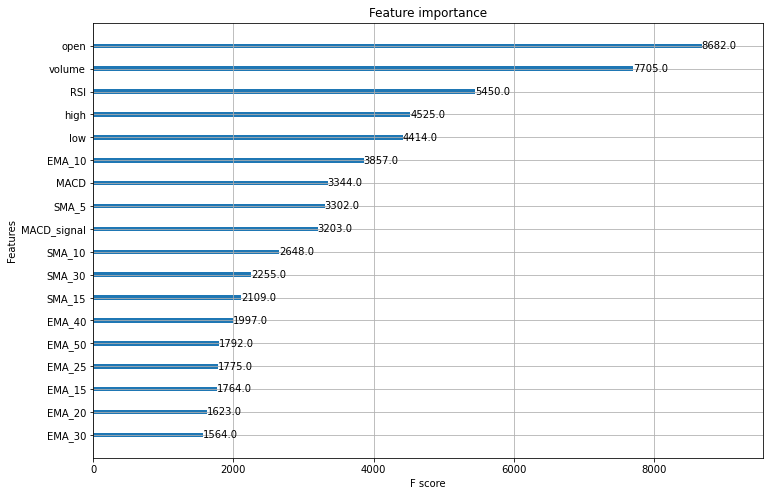

In [68]:
plot_importance(model);

#### Prediction

In [69]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [17.6    17.29   17.2572 17.095  17.225 ]
y_pred = [18.061687 17.571072 17.62642  17.484428 17.14839 ]


#### MSE and MAPE

In [70]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(y_test, y_pred)

mean_squared_error = 0.757250208567577


2.207785569086486

In [71]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

#### Calculating Percentage change on test data

- calculating percentage change day by day both on actual data and predicted data

In [72]:
X_test["Predicted_score"] =  model.predict(X_test)
X_test["close"] = y_test

X_test["close_percent_change"] = X_test.close.pct_change()
X_test["predicted_close_percent_change"] = X_test.Predicted_score.pct_change()
X_test["Date"] = df.Date[2661:]



In [73]:
X_test[["Date","close","Predicted_score","close_percent_change","predicted_close_percent_change"]][1:]

,Date,close,Predicted_score,close_percent_change,predicted_close_percent_change
3370,2023-05-02 13:00:00,17.2900,17.571072,-0.017614,-0.027163
3371,2023-05-02 14:00:00,17.2572,17.626419,-0.001897,0.003150
3372,2023-05-02 15:00:00,17.0950,17.484428,-0.009399,-0.008056
3373,2023-05-02 16:00:00,17.2250,17.148390,0.007605,-0.019219
3374,2023-05-02 17:00:00,17.1950,17.291309,-0.001742,0.008334
...,...,...,...,...,...
3738,2023-06-16 18:00:00,28.9150,28.060602,0.009955,-0.001518
3739,2023-06-16 19:00:00,28.7000,28.120188,-0.007436,0.002123
3740,2023-06-16 20:00:00,28.9300,28.007931,0.008014,-0.003992
3741,2023-06-16 21:00:00,28.9100,28.455677,-0.000691,0.015986


### June 12 to june 16 actual and predicted data to csv file

In [75]:
a = X_test[["Date","close","Predicted_score","close_percent_change","predicted_close_percent_change"]][1:]
df_out = a[(a["Date"]> "2023-06-11 00:00:00")]
df_out.to_csv("June12to16_actual&Predicted.csv")

In [89]:
# Sample output data

df_out.head()

,Date,close,Predicted_score,close_percent_change,predicted_close_percent_change
3673,2023-06-12 08:00:00,29.90,28.677572,-0.003333,-0.000074
3674,2023-06-12 09:00:00,29.50,28.419722,-0.013378,-0.008991
3675,2023-06-12 10:00:00,29.48,28.605803,-0.000678,0.006548
3676,2023-06-12 11:00:00,29.55,28.606009,0.002374,0.000007
3677,2023-06-12 12:00:00,29.70,28.686337,0.005076,0.002808


#### Next hour prediction

In [88]:
cols = X_train.columns

next_hr = X_test[cols].tail(1)
next_hr_pred = model.predict(next_hr)
next_hr_close = next_hr_pred[0]
print("Last hour close price is:", y_test.values[-1])
print("Next hour predicted close:", next_hr_close)
print("Percentage change from last hour to next hour is:",((next_hr_close/y_test.tail(1).item())-1)*100)

Last hour close price is: 28.97
Next hour predicted close: 28.681322
Percentage change from last hour to next hour is: -0.9964718751179769


### LSTM

- We will use the features from XGBoost as a feature-selection method to select important features for the purposes of prediction and discarded redundant features. 
- The selected features will be fed into the LSTM model to forecast stock prices.
- From XGBoost model feature importance 
  - open
  - volume
  - RSI
  - MACD,MACD_signal
  - high
  - low
  - ema_9 and sma_5 will be used for LSTM model

In [113]:
# Checking the data

df.head()

,Date,open,high,low,close,volume,trade_count,vwap,EMA_9,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-12-17 23:00:00,22.5000,22.5000,22.5000,22.0000,220,4,22.475818,23.016416,23.080200,22.24314,22.56819,22.914793,23.804223,34.636433,-0.466051,-0.460181
1,2021-12-20 12:00:00,22.0000,22.0000,22.0000,21.9001,100,1,22.000000,22.963297,23.025306,22.34100,22.51618,22.823460,23.730890,35.269264,-0.480333,-0.464696
2,2021-12-20 13:00:00,21.9001,21.9001,21.9001,22.8800,150,1,21.900100,22.864494,22.928657,22.32900,22.41618,22.737460,23.634893,24.151480,-0.493487,-0.470996
3,2021-12-20 14:00:00,22.1300,22.9900,22.1300,22.7000,213557,947,22.690652,22.765832,22.832026,22.18402,22.30558,22.604133,23.535563,43.128154,-0.424089,-0.460922
4,2021-12-20 15:00:00,22.8800,23.0000,22.5300,22.9700,260743,1476,22.669500,22.777485,22.836519,22.29602,22.29158,22.563467,23.473230,41.447254,-0.378560,-0.443491


In [162]:
# Creating dataframe with only important features

df1 = df[['open', 'high', 'low', 'close', 'volume','EMA_9','SMA_5','RSI','MACD','MACD_signal']]

df1.head()

,open,high,low,close,volume,EMA_9,SMA_5,RSI,MACD,MACD_signal
0,22.5000,22.5000,22.5000,22.0000,220,23.016416,22.24314,34.636433,-0.466051,-0.460181
1,22.0000,22.0000,22.0000,21.9001,100,22.963297,22.34100,35.269264,-0.480333,-0.464696
2,21.9001,21.9001,21.9001,22.8800,150,22.864494,22.32900,24.151480,-0.493487,-0.470996
3,22.1300,22.9900,22.1300,22.7000,213557,22.765832,22.18402,43.128154,-0.424089,-0.460922
4,22.8800,23.0000,22.5300,22.9700,260743,22.777485,22.29602,41.447254,-0.378560,-0.443491


#### Splitting data to train, validation and test dataset

In [163]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df1.shape[0] * (1-test_size))
valid_split_idx = int(df1.shape[0] * (1-(valid_size+test_size)))

train_df  = df1.loc[:valid_split_idx].copy()
valid_df  = df1.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df1.loc[test_split_idx+1:].copy()


In [164]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(2192, 10)
(469, 10)
(469, 10)


#### Rescaling the Features

In [165]:
from sklearn.preprocessing import MinMaxScaler

In [166]:
scaler = MinMaxScaler()

In [167]:
# Scaling training data and validation data

cols = ['open', 'high', 'low', 'close', 'volume', 'EMA_9', 'SMA_5', 'RSI',
       'MACD', 'MACD_signal']

train_df[cols] = scaler.fit_transform(train_df[cols])
valid_df[cols] = scaler.fit_transform(valid_df[cols])

In [179]:
train_df.head()

,open,high,low,close,volume,EMA_9,SMA_5,RSI,MACD,MACD_signal
0,0.621718,0.609039,0.629133,0.591568,0.000059,0.694336,0.625768,0.298157,0.328490,0.275702
1,0.599466,0.587100,0.606792,0.587181,0.000027,0.691710,0.630250,0.304952,0.322608,0.273553
2,0.595020,0.582716,0.602328,0.630215,0.000040,0.686825,0.629700,0.185574,0.317191,0.270555
3,0.605251,0.630540,0.612601,0.622310,0.058184,0.681947,0.623060,0.389337,0.345772,0.275350
4,0.638629,0.630978,0.630474,0.634168,0.071041,0.682523,0.628190,0.371288,0.364522,0.283646


#### Dividing into X and Y sets for the model building

In [169]:
y_train = df_train['close'].copy()
X_train = df_train.drop(['close'], 1)

y_val = valid_df['close'].copy()
X_val = valid_df.drop(['close'], 1)

y_test = test_df['close'].copy()
X_test = test_df.drop(['close'], 1)

In [172]:
print(X_train.shape)
print(y_train.shape)
print()
print(y_val.shape)
print(X_val.shape)
print()
print(y_test.shape)
print(X_test.shape)

(2504, 9)
(2504,)

(469,)
(469, 9)

(469,)
(469, 9)


#### Converting the training and testing data shapes into a 3-dimensional space to make it suitable for LSTMs

In [175]:
X_train = X_train.values.reshape(2504, 9,1)
X_val = X_val.values.reshape(469, 9,1)
X_test = X_test.values.reshape(469, 9,1)

In [176]:
print(X_train.shape)
print(y_train.shape)
print()
print(y_val.shape)
print(X_val.shape)
print()
print(y_test.shape)
print(X_test.shape)

(2504, 9, 1)
(2504,)

(469,)
(469, 9, 1)

(469,)
(469, 9, 1)


#### Building LSTM Model

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Build The Architecture

model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1))

ModuleNotFoundError: No module named 'tensorflow'

In [178]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sanja\\anaconda3\\Lib\\site-packages\\numpy\\~libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.




    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for jax: filename=jax-0.4.10-py3-none-any.whl size=1480617 sha256=37cedc0537c313c39ffff4c00a6d3e7d92fe047c382ed2ff5fcb1d0dc78a207e
  Stored in directory: c:\users\sanja\appdata\local\pip\cache\wheels\e5\6c\70\7c6be85fa56f05480fe043bdf0d4f6ec316b122be21e098066
Successfully built jax
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
